<h1><center>CMPE 462 - Project 2<br>Implementing an SVM Classifier</center></h1>

# BetaZero

1. Baran Deniz Korkmaz - 2015400183
2. Doğukan Kalkan - 2015400132

# Imported Packages
This section introduces the imported packages, as they are the initial requirements for the implementation.

In [1]:
import scipy.io as sio
import libsvm.svmutil as svm
import libsvm.svm
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import cvxopt

# Auxiliary Resources
This section contains the auxiliary functions that we utilize for the implementation.

# 1. Data Handling Resources
This section introduces the auxiliary functions that we use to carry out data manipulations.

## a.rearrange_data(data_dict):
Description: Creates training and test data and corresponding labels.

Parameters:
1. data_dict: A dictionary that contains all the data and labels.  

Implementation Details: The function takes the dictionary containing the data and labels, splits the data into two arrays of sizes 150 and 120 which are training data and test data. The same operation is done on the labels as well.

Return Values: 
1. x_training: A 2D array(150x13) containing training data.
2. y_training: A 2D array(120x13) containing test data. 
3. x_test: A 1D array(150) containing training labels.
4. y_test: A 1D array(120) containing test labels.

In [2]:
def rearrange_data(data_dict):
    x_training = data_dict['X'][0:150]
    x_test = data_dict['X'][150:]
    y_training = []
    y_test = []
    y = data_dict['Y']
    for i in range(150):
        y_training.append(y[i][0])
    for i in range(120):
        y_test.append(y[i+150][0])
    return x_training, y_training, x_test, y_test

## b. remove_sample(X, Y, candidate)
Description: Removes the elements in specified index from both X and Y.

Parameters: 
1. X: Training Data
2. Y: Training Labels
3. candidate: index of the element that is to be removed from X and Y

Implementation Details: The parameter 'candidate' represents the index of the element to be removed from X and Y. The function removes them from X and Y if possible.

Return Values:
1. X_NEW: New Training Data
2. Y_NEW: New Training Labels

In [3]:
def remove_sample(X, Y, candidate):
    if candidate == None:
        return X, Y
    X_NEW = np.delete(np.array(X), candidate-1, axis=0)
    Y_NEW = np.delete(np.array(Y), candidate-1, axis=0)
    return X_NEW, Y_NEW

# 2. Plotting Resources
This section introduces the auxiliary functions that we use to plot tables and charts.

## a.autolabel(rects,ax):
Description: 

Parameters:
1. rects: Bars.
2. ax: A plot.

Implementation Details: Puts the y value on top of each bar.

In [4]:
# REFERENCE: https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## b.hard_margin_plot(data, config)::
Description: Displays hard margin svm results as table.

Parameters:
1. data: The list containing training accuracy, test accuracy, and the number of support vectors.
2. config: Dictionary that contains svm configurations.

In [5]:
def hard_margin_plot(data, config):
    # Rounding
    TRAINING_ACCURACY_ROUNDED = [round(data[0] * 1.0/100, 3)]
    TEST_ACCURACY_ROUNDED = [round(data[1] * 1.0/100, 3)]
    # Rounding
    x = np.arange(1)  # the label locations
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, TRAINING_ACCURACY_ROUNDED, width, label='Training')
    rects2 = ax.bar(x + width / 2, TEST_ACCURACY_ROUNDED, width, label='Test')
    ax.set_ylabel('Accuracy')
    ax.set_title('Hard-Margin SVM: ' + 'C=' + str(config['C']) + ' Eps=' + str(config['eps']) + ' NSV=' + str(data[2]))
    ax.legend()
    ax.set_xticks([])
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    fig.tight_layout()
    plt.show()

## c.results_per_c_plot(data, c, mode):
Description: Reports the results for different kernel configurations per different C values. This function is related to Task 2 and Task 4.

Parameters:
1. data: List of lists that contains the data obtained over the iterations for different kernel configurations for a specific C value. 
2. c: Array of arrays, where each array keeps the errors encountered during the logistic regression.
3. mode: Used for arranging the titles and labels for multiple use in different tasks, i.e. Task 2 and Task 4

In [6]:
def results_per_c_plot(data, c, mode):
    fig, ax = plt.subplots(1)
    column_labels = ["Kernel Type", "Degree", "Gamma", "Coef0", "Eps", "Tr Acc", "Test Acc", "nSV"]
    if mode == 1:
        plt.title('Task 2 - Soft Margin SVM: Report for C = ' + str(c))
    elif mode == 2:
        plt.title('Task 4 - Removal of Support Vectors: Report for C = ' + str(c))
        column_labels.append('Removed Sample')
    elif mode == 3:
        plt.title('Task 4 - Removal of Non-Support Vectors: Report for C = ' + str(c))
        column_labels.append('Removed Sample')
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=data, colLabels=column_labels, cellLoc='center', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(column_labels))))
    plt.show()

## d.kernel_vs_c_plot(data, c_list):
Description: Reports the number of support vectors for different c values per varying kernel configurations. This function is related to Task 3.

Parameters:
1. data: List of lists that contains the number of support vectors for different c values per different kernel configurations in subsequent indices.
2. c_list: List of c values.

In [7]:
def kernel_vs_c_plot(data, c_list):
    fig, ax = plt.subplots(1)
    plt.title('Task 3 - Kernel vs C Analysis: Report')
    column_labels = ["Kernel Description"]
    for current_c in c_list:
        column_labels.append('C = ' +  str(current_c))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=data, colLabels=column_labels, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(column_labels))))
    plt.show()

# 3. SVM Resources
This section introduces the auxiliary functions that we use for SVM.

## a. get_kernel_description(dict):
Description: Returns the description for a given kernel configuration.

Parameters:
1. dict: Dictionary for a given kernel configuration.

In [8]:
def get_kernel_description(dict):
    kernel_type = dict['kernel_type']
    degree = dict['degree']
    gamma = dict['gamma']
    coeff = dict['coef0']
    if kernel_type == 0:
        return 'Linear'
    elif kernel_type == 1:
        return 'Polynomial: Degree=' + str(degree) + ' Coef0=' + str(coeff)
    elif kernel_type == 2:
        return 'RBF: Gamma=' + str(gamma)
    elif kernel_type == 3:
        return 'Sigmoid: Gamma=' + str(gamma) + ' Coef0=' + str(coeff)
    else:
        return 'Invalid Kernel Type'

## b. get_qp_params(X, Y):
Description: Returns the parameters required for the QP solver of CVXOPT.

Parameters:
1. X: Input Data (Training Data)
2. Y: Output Data (Class Labels)

Implementation Details: Initializes the required parameters in the required form which is described extensively in the report.

Return Values: Required parameters for QP solver in the case of Hard-Margin SVM.
1. P
2. Q
3. G
4. H

In [9]:
def get_qp_params(X, Y):
    X_np = np.array(X, dtype=float)
    Y_np = np.array(Y, dtype=float)
    d = X_np.shape[1] #number of features
    N = X_np.shape[0] #number of samples
    Q = np.zeros(d+1, dtype=float).T
    P = np.zeros((d+1)**2, dtype=float).reshape(d+1, d+1)
    identity_matrix = np.identity(d, dtype=float)
    P[1:, 1:] = identity_matrix
    H = np.ones(N, dtype=float)*(-1)
    G = []
    for (x_i, y_i) in zip(X,Y):
        G.append(np.hstack(([y_i], np.multiply(x_i, y_i))))
    G = np.multiply(G,-1)
    return P,Q,G,H

# Introduction
In the project, we are assigned to apply SVM using `libsvm`. For this purpose, a data set (data.mat) is already provided. 

The road map may be initiated by importing the data and the declaration of kernel configurations that will be used in the project. First, we import the data using the function `loadmat` in `Scipy.io`. Note that the first 150 samples are used as training data, and the remaining 120 samples as test data.

In [10]:
data_dict = sio.loadmat('data.mat')
X_training, Y_training, X_test, Y_test = rearrange_data(data_dict)

The implementations must be automatized as possible. Therefore, manual configurations must be declared systematically in a way that it is easy to use and clear to read. Below, you can see one of the most popular use of dictionaries in machine learning applications. In our project, we benefit from Python dictionaries to provide a simple and efficient way of declaring the configurations that will later be used within the project. We must note that the key values of `kernel_config` must be in ordered and start by 1. Then, svm implementations and reports for corresponding kernels will be given in the same order. 

In [11]:
#
# CONFIGURATIONS
#
svm_cost_config = [0.1,1,10,100,1000]

hard_margin_svm_config = {'svm_type': 0, 'C': math.pow(10,9), 'eps': math.pow(10,-5)}

kernel_config = {1:{'kernel_type': 0, 'degree': 0, 'gamma': 0, 'coef0': 0, 'eps': 0.1},
                 2: {"kernel_type": 1, "degree": 2, "gamma": 1, "coef0": 0, "eps": 0.1},
                 3: {"kernel_type": 1, "degree": 3, "gamma": 1, "coef0": 0, "eps": 0.1},
                 4: {"kernel_type": 1, "degree": 4, "gamma": 1, "coef0": 0, "eps": 0.1},
                 5:{"kernel_type": 2, "degree": 0, "gamma": 0.001, "coef0": 0, "eps": 0.1},
                 6:{"kernel_type": 2, "degree": 0, "gamma": 0.01, "coef0": 0, "eps": 0.1},
                 7:{"kernel_type": 2, "degree": 0, "gamma": 0.1, "coef0": 0, "eps": 0.1},
                 8:{"kernel_type": 2, "degree": 0, "gamma": 1, "coef0": 0, "eps": 0.1},
                 9:{"kernel_type": 2, "degree": 0, "gamma": 10, "coef0": 0, "eps": 0.1},
                 10:{"kernel_type": 3, "degree": 0, "gamma": 0.001, "coef0": 0, "eps": 0.1},
                 11:{"kernel_type": 3, "degree": 0, "gamma": 0.01, "coef0": 0, "eps": 0.1},
                 12:{"kernel_type": 3, "degree": 0, "gamma": 0.1, "coef0": 0, "eps": 0.1},
                 13:{"kernel_type": 3, "degree": 0, "gamma": 1, "coef0": 0, "eps": 0.1},
                 14:{"kernel_type": 3, "degree": 0, "gamma": 10, "coef0": 0, "eps": 0.1}}

kernel_codes = {0 : 'Linear', 1: 'Polynomial', 2: 'RBF', 3: 'Sigmoid'}

## Task 1: Hard-Margin SVM
In this section, the training of a hard-margin linear SVM and the report for training and test classification accuracy are provided.
The hard-margin svm is configured by the dictionary named `hard_margin_svm_config` given above. 

Considering the hard-margin svm formula, we have the following parameters:
1. svm_type: Set into 0 for linear SVM.
2. C: Penalty term for error in classification.
3. eps: Error tolerance coefficient.

We set `C = 10^9` to force svm not to use any tolerance in classification as possible, and `epsilon = 10^5` for small tolerance threshold.

Below we train our hard-margin svm described above, and report the results.

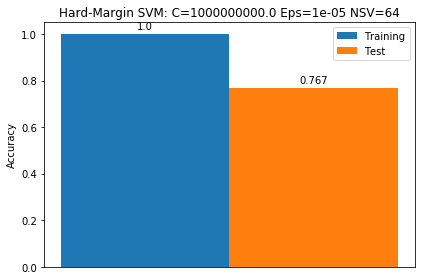

In [12]:
param = svm.svm_parameter('-q')
problem = svm.svm_problem(Y_training, X_training)

param.svm_type = hard_margin_svm_config['svm_type']
param.C = hard_margin_svm_config['C']
param.eps = hard_margin_svm_config['eps']

model = svm.svm_train(problem, param)
training_labels, training_accuracy, training_values = svm.svm_predict(Y_training, X_training, model,'-q')
test_labels, test_accuracy, test_values = svm.svm_predict(Y_test, X_test, model,'-q')
hard_margin_sv_list = model.get_SV()
hard_margin_results = [training_accuracy[0],test_accuracy[0],len(hard_margin_sv_list)]
# PLOT
hard_margin_plot(hard_margin_results,hard_margin_svm_config)

## Task 2: Soft-Margin SVM & Kernel Tricks

In this section, different Soft-Margin Suppor Vector Machines are trained with different Kernel configurations and different C values and accuracy results are shown in the tables in each of which the models are trained with a fixed C and with different Kernel configurations. 

Considering the Soft-Margin svm formula, we have the following parameters:
1. svm_type: Set to 0 for linear SVM.
2. C: Penalty term for error in classification.
3. kernel_type: Type of kernel function used in training a model.
4. gamma: A multiplier parameter for certain kernel functions
5. coef0: A constant term in kernel function.
6. eps: Error tolerance coefficient.

Before explaining the code below, variables used in the implementation will be introduced below.

### Variables:

1. param: The  declaration  of  conceptual  parameters  which  de-termines the characteristics of Support Vector Machine.

2. problem: The declaration of training data and class labels.

3. task_2_results: An array of N arrays, where N is the number of cost(C) configurations. Each array contains the configurations and results of accuracies of the models trained with associated C.

4. task_3_results: An array of N arrays, where N is the number of kernel configurations. Each array contains the number of support vectors for corresponding configuration.

5. support_vector_candidates: An array containing indices of the support vectors of an SVM. 

6. non_support_vector_candidates: An array containing indices of the non-support vectors of an SVM.

### Implementation Details:

After setting up the variables, we can start the explanation of of the training and test procedure.

We have an adjustable array of C values, which is svm_cost_config and an adjustable dictionary of kernel configurations in which all the parameters for corresponding kernel configuration are stored.

The algorithm executes the first loop for different values of C. In each iteration, different kernel configurations are used in the training procedure of an SVM. For each configuration, the corresponding parameters are accessed from the dictionary, kernel_config. After setting up the parameters, a model is trained with the function call, svm_train(problem,param) and stored in the variable named 'model'.

Afterwards, training accuracy and test accuracy are obtained through a function call, svm_predict. The parameters passed to svm_predict function are simply training/test data, training/test labels and the model itself. The training accuracy and test accuracy along with the configuration itself are stored in an array and this array is inserted into the task_2_results array with the corresponding index that actually indicates the value of C.

For Task 3, for each model, an array of support vectors for a model are obtained through a function call, get_SV(). The length of this array gives us the number of support vectors for the model, and is stored in the task_3_results array with corresponding index.

For Task 4, a support vector candidate that is to be removed is selected from the support vector candidates array. The same procedure is applied for non-support vector candidates as well.


And finally, a table depicting all the configurations, accurayc results as well as the number of support vectors is plotted for different values of C.




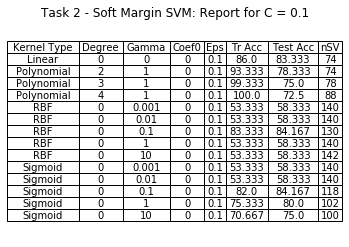

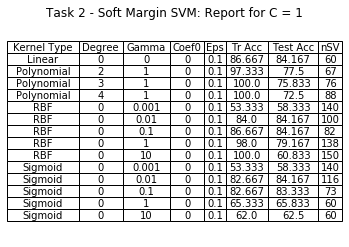

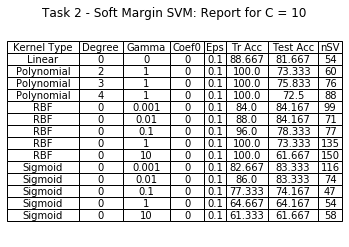

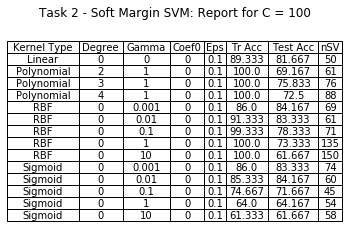

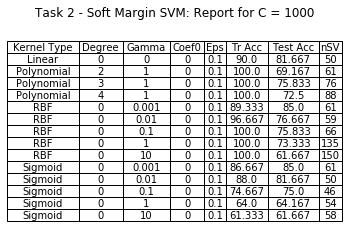

In [13]:
param = svm.svm_parameter('-q')
problem = svm.svm_problem(Y_training, X_training)
task_2_results = []
task_3_results = []
support_vector_candidates = []
non_support_vector_candidates = []
for i in range(len(svm_cost_config)):
    task_2_results.append([])
    support_vector_candidates.append([])
    non_support_vector_candidates.append([])

for index,j in enumerate(kernel_config):
    kernel_description = get_kernel_description(kernel_config[j])
    task_3_results.append([kernel_description])

for i,current_c in enumerate(svm_cost_config):
    param.C = current_c
    for index,j in enumerate(kernel_config.keys()):
        param.kernel_type = kernel_config[j]['kernel_type']
        param.degree = kernel_config[j]['degree']
        param.gamma = kernel_config[j]['gamma']
        param.coef0 = kernel_config[j]['coef0']
        param.eps = kernel_config[j]['eps']
        model = svm.svm_train(problem, param)
        training_labels, training_accuracy, training_values = svm.svm_predict(Y_training, X_training, model,'-q')
        test_labels, test_accuracy, test_values = svm.svm_predict(Y_test, X_test, model,'-q')
        nSV = len(model.get_SV())
        task_2_results[i].append([kernel_codes[kernel_config[j]['kernel_type']], kernel_config[j]['degree'],
                                  kernel_config[j]['gamma'], kernel_config[j]['coef0'],
                                  kernel_config[j]['eps'], round(training_accuracy[0], 3),
                                  round(test_accuracy[0], 3), nSV])
        task_3_results[index].append(nSV)
        support_vector_indices = model.get_sv_indices()
        non_support_vector_indices = [i for i in range(1,151) if i not in support_vector_indices]
        support_vector_candidates[i].append(random.choice(support_vector_indices))
        if len(non_support_vector_indices) == 0:
            non_support_vector_candidates[i].append(None)
        else:
            non_support_vector_candidates[i].append(random.choice(non_support_vector_indices))
            
# PLOT
for i,current_c in enumerate(svm_cost_config):
    results_per_c_plot(task_2_results[i], current_c, mode = 1)

## Task 3: Support Vector Analysis

As explained clearly above, for each kernel configuration, the corresponding array inside the array 'task_3_results' contains the number of support vectors that is obtained in each iteration above. Here, only the table is plotted.

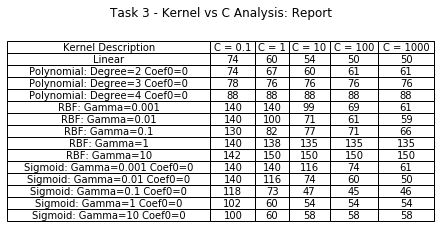

In [14]:
# PLOT
kernel_vs_c_plot(task_3_results, svm_cost_config)

## Task 4: Decision Boundary Analysis
In this section, we randomly remove either a support vector or non-support vector from our training data from the models obtained in Task 2, and retrain our models. 

The reports are provided below which shows how the removal of a data sample that is either a support vector or not affect the model decision boundary. 

Theoretically, we anticipate that the removal of non-support vector does not change the decision boundary, since the decision boundary is determined by the support vectors themselves. However, otherwise, the decision boundary may change. Below you see the tables presenting our experimental results.

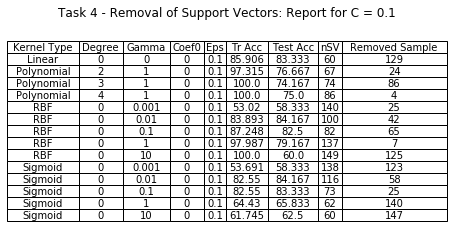

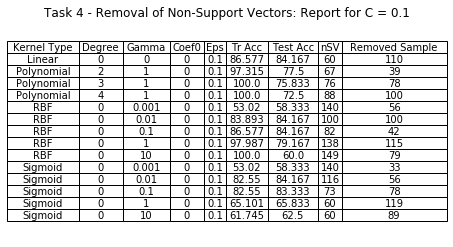

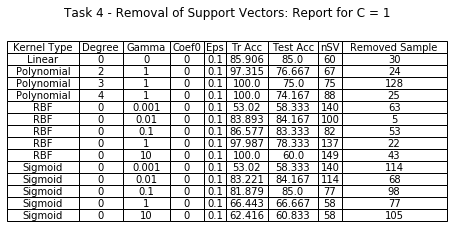

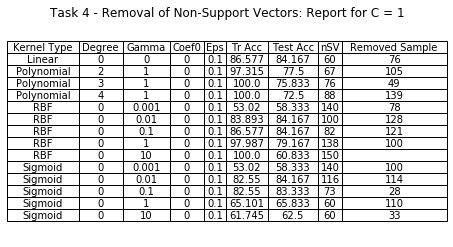

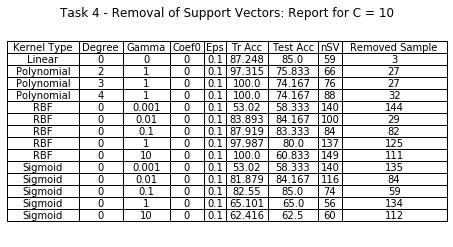

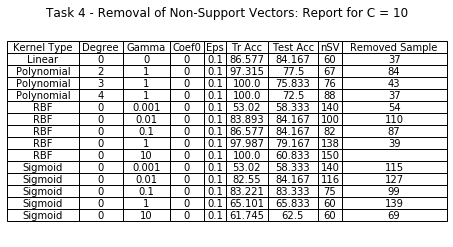

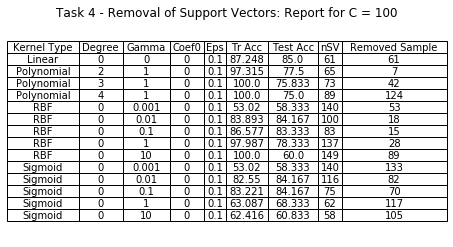

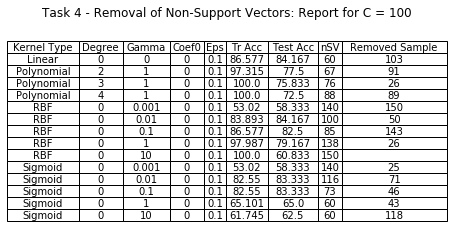

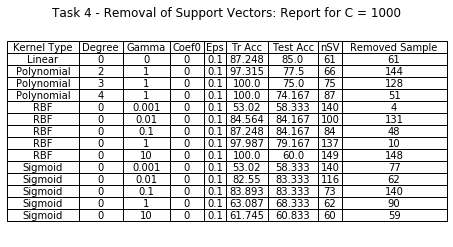

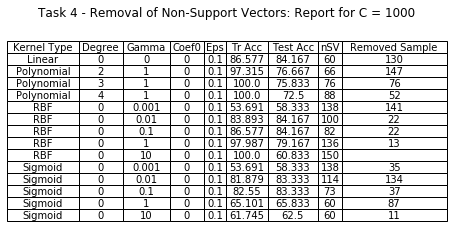

In [15]:
task_4_results_SV = []
task_4_results_NSV = []

for i in range(len(svm_cost_config)):
    task_4_results_SV.append([])
    task_4_results_NSV.append([])
    
#SUPPORT VECTOR REMOVAL
for i,current_c in enumerate(svm_cost_config):
    param.C = current_c
    for index,j in enumerate(kernel_config.keys()):
        X, Y = remove_sample(X_training, Y_training, support_vector_candidates[i][index])
        param = svm.svm_parameter('-q')
        problem = svm.svm_problem(Y, X)
        param.kernel_type = kernel_config[j]['kernel_type']
        param.degree = kernel_config[j]['degree']
        param.gamma = kernel_config[j]['gamma']
        param.coef0 = kernel_config[j]['coef0']
        param.eps = kernel_config[j]['eps']
        model = svm.svm_train(problem, param)
        training_labels, training_accuracy, training_values = svm.svm_predict(Y, X, model,'-q')
        test_labels, test_accuracy, test_values = svm.svm_predict(Y_test, X_test, model,'-q')
        nSV = len(model.get_SV())
        task_4_results_SV[i].append([kernel_codes[kernel_config[j]['kernel_type']], kernel_config[j]['degree'],
                                  kernel_config[j]['gamma'], kernel_config[j]['coef0'],
                                  kernel_config[j]['eps'], round(training_accuracy[0], 3),
                                  round(test_accuracy[0], 3), nSV, support_vector_candidates[i][index]])
        
#NONSUPPORT VECTOR REMOVAL
for i,current_c in enumerate(svm_cost_config):
    param.C = current_c
    for index,j in enumerate(kernel_config.keys()):
        X, Y = remove_sample(X_training, Y_training, non_support_vector_candidates[i][index])
        param = svm.svm_parameter('-q')
        problem = svm.svm_problem(Y, X)
        param.kernel_type = kernel_config[j]['kernel_type']
        param.degree = kernel_config[j]['degree']
        param.gamma = kernel_config[j]['gamma']
        param.coef0 = kernel_config[j]['coef0']
        param.eps = kernel_config[j]['eps']
        model = svm.svm_train(problem, param)
        training_labels, training_accuracy, training_values = svm.svm_predict(Y, X, model,'-q')
        test_labels, test_accuracy, test_values = svm.svm_predict(Y_test, X_test, model,'-q')
        nSV = len(model.get_SV())
        task_4_results_NSV[i].append([kernel_codes[kernel_config[j]['kernel_type']], kernel_config[j]['degree'],
                                  kernel_config[j]['gamma'], kernel_config[j]['coef0'],
                                  kernel_config[j]['eps'], round(training_accuracy[0], 3),
                                  round(test_accuracy[0], 3), nSV, non_support_vector_candidates[i][index]])



# PLOT
for i,current_c in enumerate(svm_cost_config):
    results_per_c_plot(task_4_results_SV[i], current_c, mode = 2)
    results_per_c_plot(task_4_results_NSV[i], current_c, mode = 3)

Please refer to the report for detailed observations about the experimental outcomes.

### Task 5: Bonus Task
In this section we are asked to solve the problem provided in the lecture slides called `Toy Example` by using `CVXOPT`, a software package for convex optimization based on the Python programming language.

We extract the parameters required for the QP solver from our training data by `get_qp_params` auxiliary function. After the parameters are supplied, the QP solver returns the optimal solution shown as below.

Please refer to the report for detailed explanations about the parameters of QP solver.

In [16]:
#Toy Example
X_toy = np.array([[0.0,0.0],[2.0,2.0],[2.0,0.0],[3.0,0.0]])
Y_toy = np.array([-1.0,-1.0,1.0,1.0])
P_toy, Q_toy, G_toy, H_toy = get_qp_params(X_toy, Y_toy)
P_toy, Q_toy, G_toy, H_toy = cvxopt.matrix(P_toy),cvxopt.matrix(Q_toy),cvxopt.matrix(G_toy),cvxopt.matrix(H_toy)
solution_toy = cvxopt.solvers.qp(P=P_toy, q=Q_toy, G=G_toy, h=H_toy)
print(solution_toy['x'])

     pcost       dcost       gap    pres   dres
 0:  3.2653e-01  1.9592e+00  6e+00  2e+00  4e+00
 1:  1.5796e+00  8.5663e-01  7e-01  0e+00  2e-15
 2:  1.0195e+00  9.9227e-01  3e-02  1e-16  1e-15
 3:  1.0002e+00  9.9992e-01  3e-04  2e-16  2e-15
 4:  1.0000e+00  1.0000e+00  3e-06  3e-16  7e-16
 5:  1.0000e+00  1.0000e+00  3e-08  4e-16  7e-16
Optimal solution found.
[-1.00e+00]
[ 1.00e+00]
[-1.00e+00]



## References
The references utilized in the implementation and documentation of the project are listed below:
* https://en.wikipedia.org/wiki/Support_vector_machine
* http://cvxopt.org/userguide/coneprog.html#quadratic-programming